In [1]:
import os
import random
import shutil
from tqdm import tqdm
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Input, Dropout
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import PIL.Image

In [ ]:
# Download the dataset
path = kagglehub.dataset_download("hearfool/vggface2")
print("Path to dataset files:", path)

In [ ]:
# Parameters
NUM_CLASSES = 40
IMAGES_PER_CLASS = 200
TRAIN_RATIO = 0.8
IMG_SIZE = (112, 112)
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

# Define directories
original_dir = os.path.join(path, "train")
output_dir = "vggface2_split"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
# Get all class directories
classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

# Select 40 classes randomly
selected_classes = random.sample(classes, NUM_CLASSES)

for cls in tqdm(selected_classes, desc="Processing classes"):
    cls_path = os.path.join(original_dir, cls)
    images = [img for img in os.listdir(cls_path) if img.endswith(".jpg")]

    # Ensure we have at least 200 images
    if len(images) < IMAGES_PER_CLASS:
        print(f"Skipping class {cls} (not enough images)")
        continue

    # Randomly select 200 images
    selected_images = random.sample(images, IMAGES_PER_CLASS)

    # Split into train and test
    split_index = int(TRAIN_RATIO * IMAGES_PER_CLASS)
    train_images = selected_images[:split_index]
    test_images = selected_images[split_index:]

    # Copy to train directory
    train_cls_dir = os.path.join(train_dir, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    for img in train_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_cls_dir, img))

    # Copy to test directory
    test_cls_dir = os.path.join(test_dir, cls)
    os.makedirs(test_cls_dir, exist_ok=True)
    for img in test_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(test_cls_dir, img))

print("Dataset split completed.")

In [5]:
# Preprocessing function with Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

def preprocess_with_augmentation(features, labels):
    features = tf.cast(features, tf.float32) / 255.0  # Normalize
    features = data_augmentation(features)
    return features, labels

def load_images_from_directory(folder_path, img_size=(112, 112)):
    labels = []
    images = []
    class_names = sorted(os.listdir(folder_path))
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for filename in os.listdir(class_folder):
            if filename.endswith(('.tif', '.jpg', '.png')):
                img_path = os.path.join(class_folder, filename)
                try:
                    img = PIL.Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)  # Resize image
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image: {img_path}")
                    continue
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

def create_tf_datasets():
    train_ds, train_labels, train_classes = load_images_from_directory(train_dir, IMG_SIZE)
    test_ds, test_labels, _ = load_images_from_directory(test_dir, IMG_SIZE)

    train_tensor_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels))
    train_tensor_ds = train_tensor_ds.map(preprocess_with_augmentation).shuffle(5000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    test_tensor_ds = tf.data.Dataset.from_tensor_slices((test_ds, test_labels))
    test_tensor_ds = test_tensor_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    return train_tensor_ds, test_tensor_ds, train_classes

Resuming download from 14680064 bytes (2479331030 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/hearfool/vggface2?dataset_version_number=1 (14680064/2494011094) bytes left.


100%|██████████| 2.32G/2.32G [00:18<00:00, 134MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1


Processing classes:  18%|█▊        | 7/40 [00:00<00:00, 60.70it/s]

Skipping class n000010 (not enough images)


Processing classes:  35%|███▌      | 14/40 [00:00<00:00, 54.90it/s]

Skipping class n000189 (not enough images)


Processing classes: 100%|██████████| 40/40 [00:00<00:00, 44.02it/s]


Dataset split completed.


In [6]:
# Define ResNet-18 Architecture with Dropout
def residual_block(inputs, filters, stride=1):
    shortcut = inputs

    # First convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=stride, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    # Adjust shortcut if necessary
    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding="same", use_bias=False)(inputs)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [7]:
def build_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolution and max-pooling
    x = Conv2D(64, kernel_size=7, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    # Global average pooling, dropout, and dense layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout layer
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

In [8]:
# Generate TensorFlow datasets
train_ds, test_ds, class_names = create_tf_datasets()
num_classes = len(class_names)

# Build and compile the model
input_shape = IMG_SIZE + (3,)
resnet18 = build_resnet18(input_shape, num_classes)
resnet18.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks for Early Stopping and Model Checkpoint
checkpoint_path = "resnet18_best.keras"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


In [9]:
# Train the model
history = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Save the final model
resnet18.save("resnet18_final_with_dropout.h5")
print("Model training completed and saved.")

Epoch 1/3
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0499 - loss: 4.1794
Epoch 1: val_loss improved from inf to 5.55981, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 86s 27ms/step - accuracy: 0.0499 - loss: 4.1787 - val_accuracy: 0.0434 - val_loss: 5.5598
Epoch 2/3
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0944 - loss: 3.4060
Epoch 2: val_loss improved from 5.55981 to 3.17570, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 60s 24ms/step - accuracy: 0.0944 - loss: 3.4058 - val_accuracy: 0.1493 - val_loss: 3.1757
Epoch 3/3
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1342 - loss: 3.1624
Epoch 3: val_loss improved from 3.17570 to 2.76024, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 83s 25ms/step - accuracy: 0.1342 - loss: 3.1624 - val_accuracy: 0.2151 - val_loss: 2.7602


Model training completed and saved.


In [10]:
# Additional training
new_history1 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6,
    initial_epoch=3,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 4/6
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1571 - loss: 3.0098
Epoch 4: val_loss improved from 2.76024 to 2.65915, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 62s 25ms/step - accuracy: 0.1571 - loss: 3.0098 - val_accuracy: 0.2270 - val_loss: 2.6592
Epoch 5/6
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1875 - loss: 2.8614
Epoch 5: val_loss improved from 2.65915 to 2.52277, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - accuracy: 0.1875 - loss: 2.8614 - val_accuracy: 0.2704 - val_loss: 2.5228
Epoch 6/6
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2212 - loss: 2.6803
Epoch 6: val_loss improved from 2.52277 to 2.48761, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 84s 25ms/step - accuracy: 0.2212 - loss: 2.6804 - val_accuracy: 0.2763 - val_loss: 2.4876


Model training completed and saved.


In [11]:
# Additional training
new_history2 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=9,
    initial_epoch=6,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 7/9
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2546 - loss: 2.5286
Epoch 7: val_loss did not improve from 2.48761
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 60s 24ms/step - accuracy: 0.2546 - loss: 2.5286 - val_accuracy: 0.2717 - val_loss: 2.7691
Epoch 8/9
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2955 - loss: 2.3901
Epoch 8: val_loss improved from 2.48761 to 2.19856, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 60s 24ms/step - accuracy: 0.2955 - loss: 2.3901 - val_accuracy: 0.3691 - val_loss: 2.1986
Epoch 9/9
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3269 - loss: 2.2740
Epoch 9: val_loss improved from 2.19856 to 2.11256, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 65s 25ms/step - accuracy: 0.3268 - loss: 2.2741 - val_accuracy: 0.3743 - val_loss: 2.1126


Model training completed and saved.


In [13]:
# Additional training
new_history3 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=12,
    initial_epoch=9,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 10/12
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3666 - loss: 2.1441
Epoch 10: val_loss improved from 2.11256 to 1.89416, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 62s 25ms/step - accuracy: 0.3666 - loss: 2.1441 - val_accuracy: 0.4375 - val_loss: 1.8942
Epoch 11/12
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3979 - loss: 2.0182
Epoch 11: val_loss improved from 1.89416 to 1.80552, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - accuracy: 0.3979 - loss: 2.0182 - val_accuracy: 0.4664 - val_loss: 1.8055
Epoch 12/12
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4179 - loss: 1.9290
Epoch 12: val_loss did not improve from 1.80552
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - accuracy: 0.4179 - loss: 1.9290 - val_accuracy: 0.4434 - val_loss: 2.0514


Model training completed and saved.


In [20]:
# Additional training
new_history4 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=14,
    initial_epoch=12,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 13/14
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4472 - loss: 1.8152
Epoch 13: val_loss improved from 1.80552 to 1.65873, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - accuracy: 0.4471 - loss: 1.8153 - val_accuracy: 0.5145 - val_loss: 1.6587
Epoch 14/14
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4673 - loss: 1.7885
Epoch 14: val_loss did not improve from 1.65873
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 63s 26ms/step - accuracy: 0.4673 - loss: 1.7885 - val_accuracy: 0.5112 - val_loss: 1.7044


Model training completed and saved.


In [24]:
# Additional training
new_history5 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=16,
    initial_epoch=14,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 15/16
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4993 - loss: 1.6699
Epoch 15: val_loss did not improve from 1.65873
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.4993 - loss: 1.6699 - val_accuracy: 0.5007 - val_loss: 1.7082
Epoch 16/16
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5183 - loss: 1.6160
Epoch 16: val_loss did not improve from 1.65873
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - accuracy: 0.5183 - loss: 1.6159 - val_accuracy: 0.5164 - val_loss: 1.6860


Model training completed and saved.


In [37]:
# Additional training
new_history6= resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=18,
    initial_epoch=16,
    callbacks=[checkpoint_cb]
)
# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 17/18
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5684 - loss: 1.4013
Epoch 17: val_loss improved from 1.55230 to 1.36731, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 61s 26ms/step - accuracy: 0.5684 - loss: 1.4013 - val_accuracy: 0.5901 - val_loss: 1.3673
Epoch 18/18
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6237 - loss: 1.2597
Epoch 18: val_loss did not improve from 1.36731
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - accuracy: 0.6237 - loss: 1.2597 - val_accuracy: 0.5849 - val_loss: 1.4300


Model training completed and saved.


In [41]:
# Additional training
new_history6= resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    initial_epoch=18,
    callbacks=[checkpoint_cb]
)
# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 19/20
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6262 - loss: 1.2080
Epoch 19: val_loss improved from 1.36731 to 1.32416, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 71s 26ms/step - accuracy: 0.6262 - loss: 1.2082 - val_accuracy: 0.6204 - val_loss: 1.3242
Epoch 20/20
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6278 - loss: 1.2208
Epoch 20: val_loss did not improve from 1.32416
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 71s 25ms/step - accuracy: 0.6278 - loss: 1.2208 - val_accuracy: 0.5730 - val_loss: 1.4810


Model training completed and saved.


In [48]:
# Additional training
new_history6= resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=22,
    initial_epoch=20,
    callbacks=[checkpoint_cb]
)
# Save the updated training history
# Save the model
resnet18.save("resnet18_updated2.h5")
print("Model training completed and saved.")

Epoch 21/22
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6572 - loss: 1.1472
Epoch 21: val_loss improved from 1.32416 to 1.10802, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 63s 27ms/step - accuracy: 0.6572 - loss: 1.1472 - val_accuracy: 0.6914 - val_loss: 1.1080
Epoch 22/22
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6661 - loss: 1.1196
Epoch 22: val_loss did not improve from 1.10802
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 82s 26ms/step - accuracy: 0.6661 - loss: 1.1196 - val_accuracy: 0.6691 - val_loss: 1.1999


Model training completed and saved.


In [56]:
from google.colab import drive
drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/models/final/resnet18_updated2.h5"
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)


Mounted at /content/drive
Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [58]:
# Additional training
new_history6= resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=24,
    initial_epoch=22,
    callbacks=[checkpoint_cb]
)
# Save the updated training history
# Save the model
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 23/24
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6793 - loss: 1.0870
Epoch 23: val_loss did not improve from 1.10802
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 62s 26ms/step - accuracy: 0.6793 - loss: 1.0870 - val_accuracy: 0.6283 - val_loss: 1.3827
Epoch 24/24
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6942 - loss: 1.0157
Epoch 24: val_loss did not improve from 1.10802
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - accuracy: 0.6942 - loss: 1.0158 - val_accuracy: 0.6776 - val_loss: 1.1092


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [64]:
# Additional training
new_history6= resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=26,
    initial_epoch=24,
    callbacks=[checkpoint_cb]
)
# Save the updated training history
# Save the model
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 25/26
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6774 - loss: 1.0273
Epoch 25: val_loss did not improve from 1.10802
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 60s 24ms/step - accuracy: 0.6774 - loss: 1.0273 - val_accuracy: 0.6770 - val_loss: 1.1813
Epoch 26/26
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7094 - loss: 0.9673
Epoch 26: val_loss did not improve from 1.10802
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - accuracy: 0.7094 - loss: 0.9673 - val_accuracy: 0.6875 - val_loss: 1.1659


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [68]:
# Additional training
new_history7 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=28,
    initial_epoch=26,
    callbacks=[checkpoint_cb]
)
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)


Epoch 27/28
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7296 - loss: 0.8934
Epoch 27: val_loss did not improve from 1.10802
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 65s 27ms/step - accuracy: 0.7296 - loss: 0.8934 - val_accuracy: 0.5559 - val_loss: 1.8418
Epoch 28/28
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7351 - loss: 0.8922
Epoch 28: val_loss improved from 1.10802 to 0.97597, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 80s 27ms/step - accuracy: 0.7350 - loss: 0.8923 - val_accuracy: 0.7204 - val_loss: 0.9760


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [70]:
# Additional training
new_history8 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    initial_epoch=28,
    callbacks=[checkpoint_cb]
)
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 29/30
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7337 - loss: 0.8748
Epoch 29: val_loss did not improve from 0.97597
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 64s 25ms/step - accuracy: 0.7337 - loss: 0.8748 - val_accuracy: 0.7204 - val_loss: 1.0141
Epoch 30/30
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7511 - loss: 0.8276
Epoch 30: val_loss improved from 0.97597 to 0.95181, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - accuracy: 0.7511 - loss: 0.8276 - val_accuracy: 0.7362 - val_loss: 0.9518


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [72]:
# Additional training
new_history9 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=32,
    initial_epoch=30,
    callbacks=[checkpoint_cb]
)
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 31/32
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7652 - loss: 0.7639
Epoch 31: val_loss did not improve from 0.95181
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - accuracy: 0.7652 - loss: 0.7639 - val_accuracy: 0.6888 - val_loss: 1.1094
Epoch 32/32
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7576 - loss: 0.7771
Epoch 32: val_loss did not improve from 0.95181
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - accuracy: 0.7576 - loss: 0.7772 - val_accuracy: 0.7145 - val_loss: 1.1311


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [75]:
# Additional training
new_history10 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=34,
    initial_epoch=32,
    callbacks=[checkpoint_cb]
)
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 33/34
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7702 - loss: 0.7379
Epoch 33: val_loss did not improve from 0.95181
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 61s 24ms/step - accuracy: 0.7702 - loss: 0.7379 - val_accuracy: 0.6408 - val_loss: 1.2675
Epoch 34/34
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7709 - loss: 0.7158
Epoch 34: val_loss did not improve from 0.95181
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 62s 25ms/step - accuracy: 0.7709 - loss: 0.7158 - val_accuracy: 0.7164 - val_loss: 1.0395


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [77]:
# Additional training
new_history11 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=36,
    initial_epoch=34,
    callbacks=[checkpoint_cb]
)
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 35/36
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7853 - loss: 0.7009
Epoch 35: val_loss did not improve from 0.95181
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - accuracy: 0.7853 - loss: 0.7009 - val_accuracy: 0.7243 - val_loss: 0.9856
Epoch 36/36
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7880 - loss: 0.6761
Epoch 36: val_loss did not improve from 0.95181
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 61s 24ms/step - accuracy: 0.7880 - loss: 0.6761 - val_accuracy: 0.7421 - val_loss: 0.9809


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [79]:
# Additional training
new_history12 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=38,
    initial_epoch=36,
    callbacks=[checkpoint_cb]
)
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 37/38
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8050 - loss: 0.6292
Epoch 37: val_loss improved from 0.95181 to 0.92693, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.8049 - loss: 0.6292 - val_accuracy: 0.7612 - val_loss: 0.9269
Epoch 38/38
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8131 - loss: 0.6176
Epoch 38: val_loss improved from 0.92693 to 0.87193, saving model to resnet18_best.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 79s 35ms/step - accuracy: 0.8131 - loss: 0.6176 - val_accuracy: 0.7658 - val_loss: 0.8719


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [81]:
# Additional training
new_history13 = resnet18.fit(
    train_ds,
    validation_data=test_ds,
    epochs=40,
    initial_epoch=38,
    callbacks=[checkpoint_cb]
)
resnet18.save(save_path)
print("Model saved to Google Drive at:", save_path)

Epoch 39/40
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8068 - loss: 0.6271
Epoch 39: val_loss did not improve from 0.87193
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 64s 25ms/step - accuracy: 0.8068 - loss: 0.6271 - val_accuracy: 0.7566 - val_loss: 0.9770
Epoch 40/40
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8147 - loss: 0.6058
Epoch 40: val_loss did not improve from 0.87193
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 66s 28ms/step - accuracy: 0.8147 - loss: 0.6058 - val_accuracy: 0.7441 - val_loss: 0.9637


Model saved to Google Drive at: /content/drive/MyDrive/models/final/resnet18_updated2.h5


In [82]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = resnet18.evaluate(test_ds, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7769 - loss: 0.8481
Test Loss: 0.9637
Test Accuracy: 0.7441


In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model predictions on the test dataset
y_true = []
y_pred = []
y_pred_probs = []

# Iterate over the test dataset to collect predictions and true labels
for features, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(resnet18.predict(features))
    y_pred.extend(np.argmax(resnet18.predict(features), axis=-1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

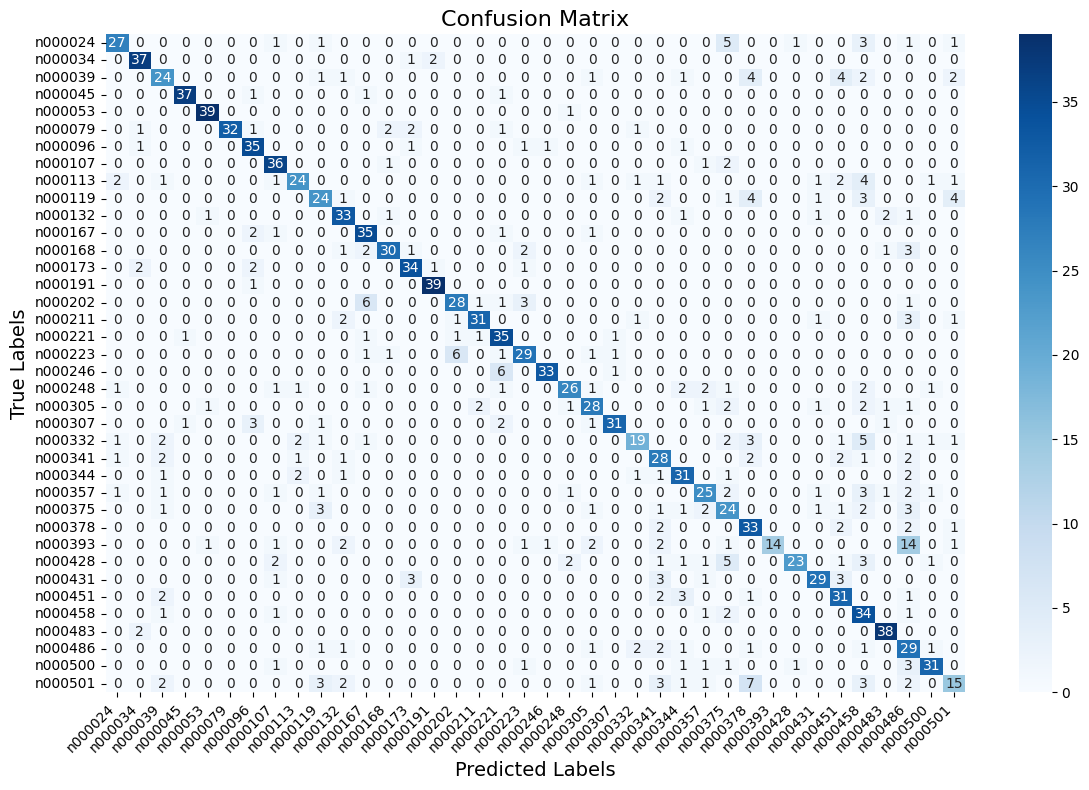

In [84]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


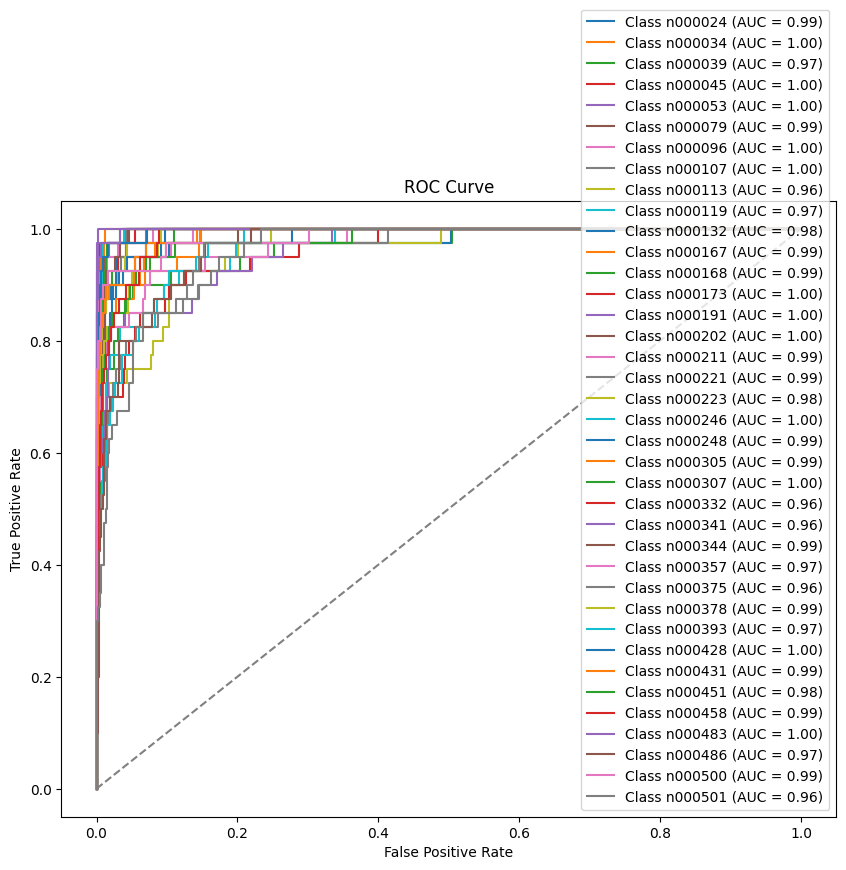

Macro-Average ROC AUC: 0.99


In [85]:
# Compute ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Add random chance line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Compute overall macro-average ROC AUC
macro_roc_auc = roc_auc_score(y_true, y_pred_probs, multi_class="ovr", average="macro")
print(f"Macro-Average ROC AUC: {macro_roc_auc:.2f}")

In [88]:
# Merge histories from all training phases
def combine_histories(*histories):
    combined_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for hist in histories:
        for key in combined_history.keys():
            combined_history[key].extend(hist.history[key])
    return combined_history

# Combine histories
full_history = combine_histories(history, new_history1, new_history2, new_history3, new_history4 , new_history6 , new_history6 , new_history6, new_history6 , new_history6,new_history7,new_history8,new_history9,new_history10,new_history11,new_history12,new_history13)

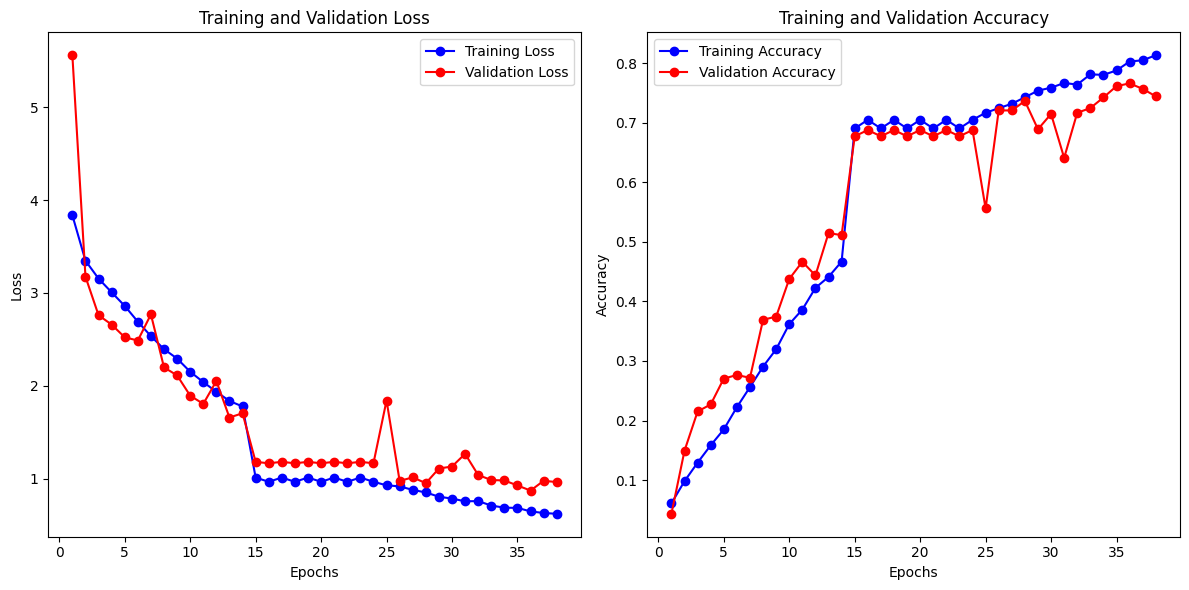

In [89]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_full_training_history(full_history):
    epochs = range(1, len(full_history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, full_history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, full_history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, full_history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, full_history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the combined training history
plot_full_training_history(full_history)
